# XLNetExtAbsSum for Abstractive Text Summarization
Brandon Castaing and Aditi Das - 12/1/2019

## Replication Steps
#### Download Code
vim ~/.ssh/bpc_mids_id_rsa

eval `ssh-agent`
ssh-add ~/.ssh/bpc_mids_id_rsa
git clone git@github.com:nlpyang/PreSumm.git
git clone git@github.com:brandon-castaing-ucb/XLNetExtAbsSum.git
cp XLNetExtAbsSum/model_builder.py PreSumm/src/models/
cp XLNetExtAbsSum/trainer.py PreSumm/src/models/
apt install python3-pip
pip3 install -r PreSumm/requirements.txt

#### Download CNN Daily Mail
cd PreSumm/bert_data
fileid="1DN7ClZCCXsk2KegmC6t4ClBwtAf5galI"
filename="cnndm.zip"
curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=${fileid}" > /dev/null
curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=${fileid}" -o ${filename}
apt install unzip
unzip cnndm.zip
mv bert_data_cnndm_final/* . && rm -rf bert_data_cnndm_final && rm cnndm.zip

#### Set up CUDA
lspci | grep -i nvidia
sudo apt install gcc-6 g++-6
sudo apt install linux-headers-$(uname -r)
sudo apt install nvidia-418
wget http://us.download.nvidia.com/tesla/418.87/nvidia-driver-local-repo-ubuntu1804-418.87.01_1.0-1_amd64.deb
sudo dpkg -i nvidia-driver-local-repo-ubuntu1804-418.87.01_1.0-1_amd64.deb
wget -c https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda_9.2.88_396.26_linux
chmod +x cuda_9.2.88_396.26_linux
./cuda_9.2.88_396.26_linux --verbose --silent --toolkit --override
./cuda_9.2.88_396.26_linux -silent -driver
export PATH="$PATH:/usr/local/cuda-9.2/bin"
echo "/usr/local/cuda-9.2/lib64" >> /etc/ld.so.conf
ldconfig
wget https://developer.nvidia.com/compute/cuda/9.2/Prod/patches/1/cuda_9.2.88.1_linux
chmod +x cuda_9.2.88.1_linux
./cuda_9.2.88.1_linux --silent --accept-eula
ln -s /usr/bin/gcc-6 /usr/local/cuda-9.2/bin/gcc
ln -s /usr/bin/g++-6 /usr/local/cuda-9.2/bin/g++
sudo reboot
export PATH="$PATH:/usr/local/cuda-9.2/bin"

nvidia-smi
nvcc --version

#### Train
**GPU PARAMS**
Batch Size: 200
Train Steps: 1000
Warm Up Steps: 100
Learning Rate: .002
Drop Out: 0.1
Accum Count: 10
Report Every: 1000
Save CHKPT: 1000

cd ~/PreSumm && mkdir ext_models && mkdir abs_models && cd src
python3 train.py -task ext -mode train -bert_data_path ../bert_data/cnndm -ext_dropout 0.1 -model_path ../ext_models -lr 2e-3 -visible_gpus 0 -report_every 1000 -save_checkpoint_steps 250 -batch_size 200 -train_steps 1001 -accum_count 10 -log_file ../logs/train_xlnet_ext -use_interval true -warmup_steps 100 -max_pos 512 -result_path ../results/train_xlnet_ext

python3 train.py -task abs -mode train -bert_data_path ../bert_data/cnndm -dec_dropout 0.1 -model_path ../abs_models -sep_optim true -lr_bert 2e-3 -lr_dec 0.1 -save_checkpoint_steps 250 -batch_size 200 -train_steps 1001 -report_every 250 -accum_count 10 -use_bert_emb true -use_interval true -warmup_steps_bert 100 -warmup_steps_dec 100 -max_pos 512 -visible_gpus 0 -log_file ../logs/train_xlnet_ext_abs -result_path ../results/train_xlnet_ext_abs -load_from_extractive ../ext_models/<MODEL>

#### Evaluate
python3 train.py -task abs -mode test -test_from ../abs_models/<MODEL>.pt -bert_data_path ../bert_data/cnndm -test_batch_size 200 -dec_dropout 0.1 -model_path ../abs_models -sep_optim true -lr_bert 2e-3 -lr_dec 0.1 -save_checkpoint_steps 250 -batch_size 200 -train_steps 1001 -report_every 250 -accum_count 10 -use_bert_emb true -use_interval true -warmup_steps_bert 100 -warmup_steps_dec 100 -max_pos 512 -visible_gpus 0 -report_rouge True -log_file ../logs/test_xlnet_ext_abs -load_from_extractive ../ext_models/<MODEL> -result_path ../results/test_xlnet_abs_ext

python3 train.py -task abs -mode validate -batch_size 200 -test_batch_size 200 -bert_data_path ../bert_data/cnndm -log_file ../logs/validate_xlnet_ext_abs -model_path ../final_models/<MODEL> -sep_optim true -use_interval true -visible_gpus 0 -max_pos 512 -max_length 200 -alpha 0.95 -min_length 50 -result_path ../results/validate_xlnet_ext_abs

## Preliminary Setup

In [1]:
# Install libraries
#!pip3 install tensorflow tensorflow-datasets tf-nightly matplotlib pyyaml h5py nltk pandas sentencepiece transformers==2.0.0 torch torchvision py-rouge
#!pip3 install torch==1.3.1+cpu torchvision==0.4.2+cpu -f https://download.pytorch.org/whl/torch_stable.html

In [14]:
# Import Libraries
from __future__ import absolute_import, division, print_function, unicode_literals
import os, sys, re, json, time, datetime, shutil
import nltk
nltk.download('punkt')
import sentencepiece as sp
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import transformers
from transformers import *
import torch
import rouge

from torch.optim import Adam
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import functools
from collections import deque
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\brand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Check versions
print(np.__version__)
print(pd.__version__)
print(tf.__version__)
print(transformers.__version__)
print(torch.__version__)

1.17.3
0.24.1
2.1.0-dev20191026
2.0.0
1.3.1+cpu


## Load XLNet and BertExtAbsSum

In [3]:
# XLNet model loading - Disclaimer credit: https://github.com/huggingface/transformers/blob/7a9aae1044aa4699310a8004f631fc0a4bdf1b65/transformers/modeling_xlnet.py#L973
model_name_or_path = 'xlnet-base-cased'
cache_dir = './model_cache'
using_tf = False
if using_tf:
    config_class, model_class, tokenizer_class = (XLNetConfig, TFXLNetModel, XLNetTokenizer)
else:
    config_class, model_class, tokenizer_class = (XLNetConfig, XLNetModel, XLNetTokenizer)
    
config = config_class.from_pretrained(model_name_or_path, cache_dir=cache_dir if cache_dir else None)
'''tokenizer = tokenizer_class.from_pretrained(model_name_or_path,
                                            do_lower_case=False,
                                            cache_dir=cache_dir if cache_dir else None)
model = model_class.from_pretrained(model_name_or_path,
                                    from_tf=bool('.ckpt' in model_name_or_path),
                                    config=config,
                                    cache_dir=cache_dir if cache_dir else None)'''
tokenizer = tokenizer_class.from_pretrained(model_name_or_path, cache_dir=cache_dir if cache_dir else None)
model = model_class.from_pretrained(model_name_or_path, cache_dir=cache_dir if cache_dir else None)

'''
# NOTE: Can't use because only Bert base is supported currently
from transformers import (
    AutoTokenizer,
    BertForMaskedLM,
    BertConfig,
    PreTrainedEncoderDecoder,
    Model2Model,
)
model = Model2Model.from_pretrained(pretrained_weights, decoder_model=pretrained_weights)
'''
print(f"Model: {model}")

# Simple test
raw_text = "Here is some encoded text using XLNet!"
encoded = tokenizer.encode(raw_text, add_special_tokens=False)
decoded = tokenizer.decode(encoded)
print(f"Raw Text: {raw_text}\nXLNet Encoded Text: {encoded}\nXLNet Decoded Text: {decoded}")

Model: XLNetModel(
  (word_embedding): Embedding(32000, 768)
  (layer): ModuleList(
    (0): XLNetLayer(
      (rel_attn): XLNetRelativeAttention(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): XLNetFeedForward(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (layer_1): Linear(in_features=768, out_features=3072, bias=True)
        (layer_2): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): XLNetLayer(
      (rel_attn): XLNetRelativeAttention(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): XLNetFeedForward(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (layer_1): Linear(in_features=768, out_features=

## Data Loading, Inspection, and EDA

In [4]:
# Disclaimer: All credit goes to https://github.com/huggingface/transformers/blob/master/examples/utils_summarization.py#L13
import os
from torch.utils.data import Dataset

class CNNDailyMailDataset(Dataset):
    """ Abstracts the dataset used to train seq2seq models.
    CNN/Daily News:
    The CNN/Daily News raw datasets are downloaded from [1]. The stories are
    stored in different files; the summary appears at the end of the story as
    sentences that are prefixed by the special `@highlight` line. To process
    the data, untar both datasets in the same folder, and pass the path to this
    folder as the "data_dir argument. The formatting code was inspired by [2].
    [1] https://cs.nyu.edu/~kcho/
    [2] https://github.com/abisee/cnn-dailymail/
    """

    def __init__(self, tokenizer, prefix="train", data_dir=""):
        assert os.path.isdir(data_dir)
        self.tokenizer = tokenizer

        # We initialize the class by listing all the files that contain
        # stories and summaries. Files are not read in memory given
        # the size of the corpus.
        self.stories_path = []
        datasets = ("cnn", "dailymail")
        for dataset in datasets:
            path_to_stories = os.path.join(data_dir, dataset, "stories")
            story_filenames_list = os.listdir(path_to_stories)
            sample_size = 500
            print(f"Found {len(story_filenames_list)} {dataset} datapoints... Using {sample_size}")
            for story_filename in story_filenames_list[:sample_size]:
                path_to_story = os.path.join(path_to_stories, story_filename)
                if not os.path.isfile(path_to_story):
                    continue
                self.stories_path.append(path_to_story)

    def __len__(self):
        return len(self.stories_path)

    def __getitem__(self, idx):
        story_path = self.stories_path[idx]
        with open(story_path, encoding="utf-8") as source:
            raw_story = source.read()
            story_lines, summary_lines = process_story(raw_story)
        return story_lines, summary_lines


def process_story(raw_story):
    """ Extract the story and summary from a story file.
    Attributes:
        raw_story (str): content of the story file as an utf-8 encoded string.
    Raises:
        IndexError: If the stoy is empty or contains no highlights.
    """
    nonempty_lines = list(
        filter(lambda x: len(x) != 0, [line.strip() for line in raw_story.split("\n")])
    )

    # for some unknown reason some lines miss a period, add it
    nonempty_lines = [_add_missing_period(line) for line in nonempty_lines]

    # gather article lines
    story_lines = []
    lines = deque(nonempty_lines)
    while True:
        try:
            element = lines.popleft()
            if element.startswith("@highlight"):
                break
            story_lines.append(element)
        except IndexError:
            # if "@highlight" is absent from the file we pop
            # all elements until there is None.
            return story_lines, []

    # gather summary lines
    summary_lines = list(filter(lambda t: not t.startswith("@highlight"), lines))

    return story_lines, summary_lines


def _add_missing_period(line):
    END_TOKENS = [".", "!", "?", "...", "'", "`", '"', u"\u2019", u"\u2019", ")"]
    if line.startswith("@highlight"):
        return line
    if line[-1] in END_TOKENS:
        return line
    return line + "."


# --------------------------
# Encoding and preprocessing
# --------------------------


def fit_to_block_size(sequence, block_size, pad_token):
    """ Adapt the source and target sequences' lengths to the block size.
    If the sequence is shorter than the block size we pad it with -1 ids
    which correspond to padding tokens.
    """
    if len(sequence) > block_size:
        return sequence[:block_size]
    else:
        sequence.extend([pad_token] * (block_size - len(sequence)))
        return sequence


def build_lm_labels(sequence, pad_token):
    """ Padding token, encoded as 0, are represented by the value -1 so they
    are not taken into account in the loss computation. """
    padded = sequence.clone()
    padded[padded == pad_token] = -1
    return padded


def build_mask(sequence, pad_token):
    """ Builds the mask. The attention mechanism will only attend to positions
    with value 1. """
    mask = torch.ones_like(sequence)
    idx_pad_tokens = sequence == pad_token
    mask[idx_pad_tokens] = 0
    return mask


def encode_for_summarization(story_lines, summary_lines, tokenizer):
    """ Encode the story and summary lines, and join them
    as specified in [1] by using `[SEP] [CLS]` tokens to separate
    sentences.
    """
    story_lines_token_ids = [
        tokenizer.add_special_tokens_single_sequence(tokenizer.encode(line))
        for line in story_lines
    ]
    summary_lines_token_ids = [
        tokenizer.add_special_tokens_single_sequence(tokenizer.encode(line))
        for line in summary_lines
    ]

    story_token_ids = [
        token for sentence in story_lines_token_ids for token in sentence
    ]
    summary_token_ids = [
        token for sentence in summary_lines_token_ids for token in sentence
    ]

    return story_token_ids, summary_token_ids


def compute_token_type_ids(batch, separator_token_id):
    """ Segment embeddings as described in [1]
    The values {0,1} were found in the repository [2].
    Attributes:
        batch: torch.Tensor, size [batch_size, block_size]
            Batch of input.
        separator_token_id: int
            The value of the token that separates the segments.
    [1] Liu, Yang, and Mirella Lapata. "Text summarization with pretrained encoders."
        arXiv preprint arXiv:1908.08345 (2019).
    [2] https://github.com/nlpyang/PreSumm (/src/prepro/data_builder.py, commit fac1217)
    """
    batch_embeddings = []
    for sequence in batch:
        sentence_num = 0
        embeddings = []
        for s in sequence:
            if s == separator_token_id:
                sentence_num += 1
            embeddings.append(sentence_num % 2)
        batch_embeddings.append(embeddings)
    return torch.tensor(batch_embeddings)

In [5]:
# DATA LOAD
train_data = CNNDailyMailDataset(tokenizer, data_dir="./cnn_daily_mail")

Found 92579 cnn datapoints... Using 500
Found 219506 dailymail datapoints... Using 500


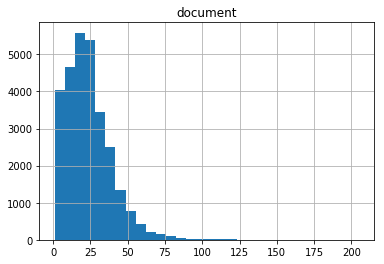

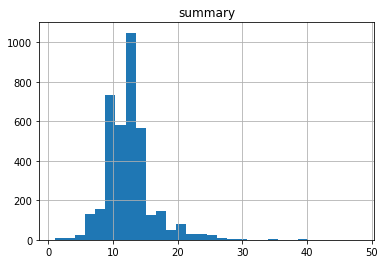

Document Word Count: 28775
Summary Word Count: 3759


In [6]:
# DATA VISUALIZATION
document_word_count, summary_word_count = [], []

for pairs in train_data:
    for word in pairs[0]:
        document_word_count.append(len(word.split()))
    for word in pairs[1]:
        summary_word_count.append(len(word.split()))

document_df = pd.DataFrame({'document': document_word_count})
summary_df = pd.DataFrame({'summary': summary_word_count})
document_df.hist(bins = 30)
summary_df.hist(bins = 30)
plt.show()

print(f"Document Word Count: {len(document_word_count)}")
print(f"Summary Word Count: {len(summary_word_count)}")

#TODO: Should add unique word count as well

## Basic XLNet Abstract Text Summarization Train + Eval Pipeline

In [7]:
# Pytorch helper function - NOTE: Determines training input per layer
def collate(data, tokenizer, block_size):
    """ List of tuple as an input. """
    # remove the files with empty an story/summary, encode and fit to block
    data = filter(lambda x: not (len(x[0]) == 0 or len(x[1]) == 0), data)
    data = [
        encode_for_summarization(story, summary, tokenizer) for story, summary in data
    ]
    data = [
        (
            fit_to_block_size(story, block_size, tokenizer.pad_token_id),
            fit_to_block_size(summary, block_size, tokenizer.pad_token_id),
        )
        for story, summary in data
    ]

    stories = torch.tensor([story for story, summary in data])
    summaries = torch.tensor([summary for story, summary in data])
    encoder_token_type_ids = compute_token_type_ids(stories, tokenizer.cls_token_id)
    encoder_mask = build_mask(stories, tokenizer.pad_token_id)
    decoder_mask = build_mask(summaries, tokenizer.pad_token_id)
    lm_labels = build_lm_labels(summaries, tokenizer.pad_token_id)

    return (
        stories,
        summaries,
        encoder_token_type_ids,
        encoder_mask,
        decoder_mask,
        lm_labels,
    )

In [8]:
# TRAIN PARAMETERS

# Define Hyper Parameters
train_batch_size = 16
gradient_accumulation_steps = 10
num_train_epochs = 25
per_gpu_train_batch_size = 0
device = torch.device('cpu')
max_grad_norm = 1 
max_steps = 10
weight_decay = 0.5

# Set up training device
if not torch.cuda.is_available():
    device = torch.device("cpu")
    #args.n_gpu = 0

else: #TODO: Set this to TRUE when we are training with a GPU!!!
    device = torch.device("cuda")
    #args.n_gpu = torch.cuda.device_count()

# Sample Data
train_sampler = RandomSampler(train_data)
model_collate_fn = functools.partial(collate, tokenizer=tokenizer, block_size=512)
train_dataloader = DataLoader(
    train_data,
    sampler=train_sampler,
    batch_size=train_batch_size,
    collate_fn=model_collate_fn,
)

# Training schedule
t_total = (len(train_dataloader) // gradient_accumulation_steps * num_train_epochs)

# Prepare the optimizer
no_decay = ['bias', 'LayerNorm.weight']

if using_tf:
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters)
else:
    optimizer= tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
#optimizer = BertSumOptimizer(model, lr, warmup_steps)

# Train
print("***** Running training *****")
print("  Num examples = %d", len(train_data))
print("  Num Epochs = %d", num_train_epochs)
print("  Instantaneous batch size per GPU = %d", per_gpu_train_batch_size)
print("  Total train batch size (w. parallel, distributed & accumulation) = %d", train_batch_size * gradient_accumulation_steps
# * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
)
print("  Gradient Accumulation steps = %d", gradient_accumulation_steps)
print("  Total optimization steps = %d", t_total)

***** Running training *****
  Num examples = %d 1000
  Num Epochs = %d 25
  Instantaneous batch size per GPU = %d 0
  Total train batch size (w. parallel, distributed & accumulation) = %d 160
  Gradient Accumulation steps = %d 10
  Total optimization steps = %d 150


In [10]:
# START TRAINING
def build_lm_labels(sequence, pad_token):
    """ Padding token, encoded as 0, are represented by the value -1 so they
    are not taken into account in the loss computation. """
    padded = sequence.clone()
    padded[padded == pad_token] = -1
    return padded

if using_tf:
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
    print(model)

    # Train and evaluate using tf.keras.Model.fit()
    fit_model = model.fit(train_data, epochs=5, steps_per_epoch=50, validation_data=train_data, validation_steps=5)
    print(f"Fit Model: {fit_model}")

    # Load the TensorFlow model in PyTorch for inspection
    model.save_pretrained('./save/')
    pytorch_model = XLNetModel.from_pretrained('./save/')
    print(f"Translated from TF to PyTorch: {pytorch_model}")

print(f"Model Before: {model}")
model.zero_grad()
model.to(device)
train_iterator = trange(num_train_epochs, desc="Epoch", disable=True)
print(f"Model After: {model}")

global_step = 0
tr_loss = 0.0
for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=True)
    for step, batch in enumerate(epoch_iterator):
        # XLNetModel forward() parameters:
        #input_ids=None, attention_mask=None, mems=None, perm_mask=None, target_mapping=None,
        #token_type_ids=None, input_mask=None, head_mask=None, inputs_embeds=None
            
        if True: # From run_summarization_finetuning.py w/ XLNet
            source, target, encoder_token_type_ids, encoder_mask, decoder_mask, lm_labels = batch

            source = source.to(device)
            target = target.to(device)
            encoder_token_type_ids = encoder_token_type_ids.to(device)
            encoder_mask = encoder_mask.to(device)
            decoder_mask = decoder_mask.to(device)
            lm_labels = lm_labels.to(device)
            
            print(source.shape)
            print(target.shape)
            
            model.train()
            
            outputs = model(
                source,
                target
                #encoder_token_type_ids=encoder_token_type_ids,
                #encoder_attention_mask=encoder_mask,
                #decoder_attention_mask=decoder_mask,
                #decoder_lm_labels=lm_labels,
            )
        else: # From run_glue.py w/ XLNet
            #NEW
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'token_type_ids': batch[2]}#, 'labels': batch[3]}
            outputs = model(**inputs)

        loss = outputs[0]
        print(loss)
        if gradient_accumulation_steps > 1:
            loss /= gradient_accumulation_steps

        loss.backward()

        tr_loss += loss.item()
        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            model.zero_grad()
            global_step += 1

        if max_steps > 0 and global_step > max_steps:
            epoch_iterator.close()
            break

    if max_steps > 0 and global_step > max_steps:
        train_iterator.close()
        break

tr_loss = tr_loss / global_step
print(" global_step = %s, average loss = %s", global_step, tr_loss)

Model Before: XLNetModel(
  (word_embedding): Embedding(32000, 768)
  (layer): ModuleList(
    (0): XLNetLayer(
      (rel_attn): XLNetRelativeAttention(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): XLNetFeedForward(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (layer_1): Linear(in_features=768, out_features=3072, bias=True)
        (layer_2): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): XLNetLayer(
      (rel_attn): XLNetRelativeAttention(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): XLNetFeedForward(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (layer_1): Linear(in_features=768, out_fe

)
torch.Size([16, 512])
torch.Size([16, 512])
tensor([[[-0.4923,  0.5648, -0.0000,  ..., -0.1711,  0.5826,  1.5979],
         [-1.3526,  0.0000, -4.9159,  ...,  0.7314,  1.0024, -0.5741],
         [-1.6308,  0.3233, -4.7997,  ...,  0.5059, -0.0000, -0.7830],
         ...,
         [-3.7729,  2.3776, -1.6315,  ...,  1.7183,  2.1114,  0.4032],
         [-2.1046,  0.0000,  0.0919,  ...,  1.4886,  1.5065,  0.0000],
         [-4.3521,  2.2154, -1.0310,  ...,  3.9035,  1.7306, -2.2345]],

        [[-1.5507, -2.2387, -3.5899,  ...,  0.2783,  1.3534,  1.5098],
         [ 1.0675, -1.2876, -4.4565,  ..., -1.0188,  0.1041,  0.8069],
         [-0.0000, -0.4530, -2.8948,  ..., -1.8764,  1.2533,  0.0000],
         ...,
         [-1.0310, -1.2517, -0.5087,  ..., -0.9041,  1.7969,  1.2310],
         [-0.0671, -1.2169, -0.0000,  ..., -0.7287,  1.0383, -0.3566],
         [ 1.2900, -0.1262, -1.6657,  ..., -0.5648,  1.0618, -0.4677]],

        [[-1.4534, -2.2966, -3.1181,  ...,  0.7230,  1.3503, -0.4952],

RuntimeError: grad can be implicitly created only for scalar outputs

## Final Output - Save Model + ROUGE Metrics/Graphs

In [15]:
#TODO: Send model outputs with labels through this call!
pred = ["Dogs are my favorite animal in the world!", "This is easy."]
label = ["Cats are my favorite feline in the country.", "This is hard."]

def prepare_results(p, r, f):
    return '\t{}:\t{}: {:5.2f}\t{}: {:5.2f}\t{}: {:5.2f}'.format(metric, 'P', 100.0 * p, 'R', 100.0 * r, 'F1', 100.0 * f)

evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                       max_n=3,
                       limit_length=True,
                       length_limit=100,
                       length_limit_type='words',
                       apply_avg=True,
                       apply_best=True,
                       alpha=0.5, # Default F1_score
                       weight_factor=1.2,
                       stemming=True)

scores = evaluator.get_scores(pred, label)

for metric, results in sorted(scores.items(), key=lambda x: x[0]):
    print(prepare_results(results['p'], results['r'], results['f']))

	rouge-1:	P: 64.58	R: 64.58	F1: 64.58
	rouge-2:	P: 46.43	R: 46.43	F1: 46.43
	rouge-3:	P:  8.33	R:  8.33	F1:  8.33
	rouge-l:	P: 69.46	R: 69.46	F1: 69.46
	rouge-w:	P: 61.29	R: 45.20	F1: 51.91
